### Required Modules

In [11]:
import torch.nn.functional as F 
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import numpy as np
import os

### Dataset And Dataloader

In [12]:
rand_seed = 3407
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)
torch.cuda.manual_seed(rand_seed)

data_folder = 'brain_dead_emotion_detection'
# /home/sysadm/Workspace/Brain Dead/data/brain_dead_emotion_detection/AUG_Train
sets = ["Train", "Test"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

num_classes = 4
batch_size = 4
epochs = 50
lr = 0.0001
image_size= 299
n_workers = 10



data_transform = {
    sets[0]: transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ColorJitter(brightness=0.5, hue=0.3),
        transforms.RandomRotation(50),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)]),
    sets[1]: transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)])
}
data_dir = os.path.join('./data', data_folder)
image_dataset = {x: datasets.ImageFolder(
    os.path.join(data_dir, x), data_transform[x]) for x in sets}

dataloaders = {x: torch.utils.data.DataLoader(
    image_dataset[x], batch_size=batch_size, shuffle=True, num_workers=n_workers, pin_memory=True) for x in sets}

dataset_size = {x: len(image_dataset[x]) for x in sets}

### Bi-Linear Convolution Neural Network Model, backboned with resnet18 (Trained on IMAGENET)

In [13]:
class BCNN(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(BCNN, self).__init__()
        features = torchvision.models.resnet18(pretrained=pretrained)
        self.conv = nn.Sequential(*list(features.children())[:-2])
        
        self.fc = nn.Sequential( # _n
            nn.Linear(512 * 512, 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 16),
            )


    def forward(self, input):
        features = self.conv(input)
        features = features.view(features.size(0), 512, 10 * 10)
        features_T = torch.transpose(features, 1, 2)
        features = torch.bmm(features, features_T) / (10 * 10)
        features = features.view(features.size(0), 512 * 512)
        features = torch.sign(features) * torch.sqrt(torch.abs(features) + 1e-12)
        features = torch.nn.functional.normalize(features)
        out = self.fc(features)
        return out

model = BCNN(num_classes=num_classes)

### Main Train Loop

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=3)


model.cuda()

max_test_acc = 0

loss_acc = {'loss':{'Train':[], 'Test':[]}, 'acc':{'Train':[], 'Test':[]}}
for e in range(epochs):

    for phase in sets:
        if phase == sets[0]:
            model.train()
        else:
            model.eval()

        running_loss = 0
        running_correct = 0

        for input, label in dataloaders[phase]:
            input = input.to(device)
            label = label.to(device)

            with torch.set_grad_enabled(phase == sets[0]):
                output = model(input)
                _, pred = torch.max(output, 1)
                loss = criterion(output, label)

                if phase == sets[0]:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * input.size(0)
            running_correct += torch.sum(pred == label.data)

        epoch_loss = running_loss / dataset_size[phase]
        epoch_acc = running_correct.double() / dataset_size[phase]

        if phase == sets[1]:
            scheduler.step(epoch_loss)
            # save best model
            if max_test_acc < epoch_acc:
                max_test_acc = epoch_acc
                checkpoint = {
                    'model':model.state_dict(),
                    'optimizer':optimizer.state_dict(),
                    'epoch':e
                }
                torch.save(checkpoint, './output/best_model_lrplateu_n.pt')

        loss_acc['loss'][phase].append(epoch_loss)
        loss_acc['acc'][phase].append(epoch_acc)
        # print(f'{phase}: Epochs = {e}, Loss = {epoch_loss:.3f}, Accuracy = {100*epoch_acc:.2f}')
    # print()
# print(f'Test accuracy: {max_test_acc}')

### Loss vs Epoch And Accuracy vs Epoch plots

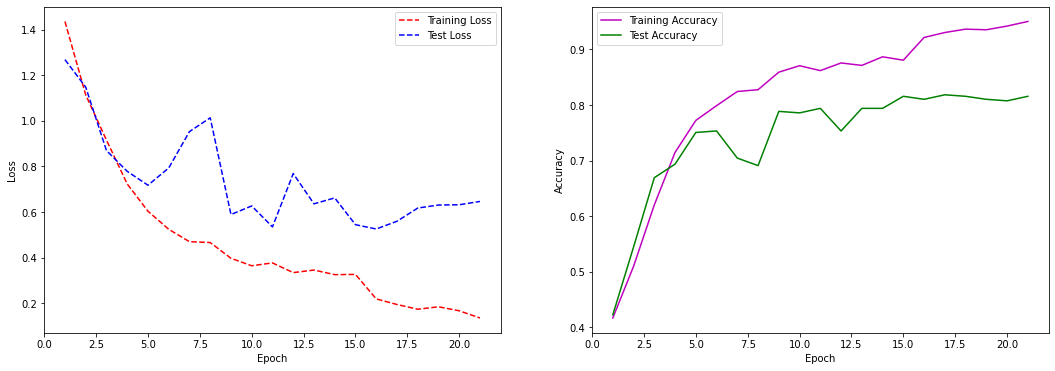

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

train_loss_list, val_loss_list, train_acc_list, val_acc_list = loss_acc['loss']['Train'], loss_acc['loss']['Test'], loss_acc['acc']['Train'], loss_acc['acc']['Test']

epoch_count = range(1, len(train_loss_list) + 1)

fig = plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(epoch_count, train_loss_list, 'r--')
plt.plot(epoch_count, val_loss_list, 'b--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Test Loss'])

plt.subplot(1, 2, 2)
plt.plot(epoch_count, [i.cpu() for i in train_acc_list], 'm-')
plt.plot(epoch_count, [i.cpu() for i in val_acc_list], 'g-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend(['Training Accuracy', 'Test Accuracy'])

plt.show()


### Getting Predictions on Test Data

In [16]:
checkpoint = torch.load('./output/best_model_woaug_lrplateu_n.pt')
model = BCNN(num_classes=num_classes)

model.load_state_dict(checkpoint['model'])
model.to(device)
model.eval()

y_true, y_pred = [], []
for input, label in dataloaders[sets[1]]:
    input = input.to(device)
    label = label.to(device)

    with torch.no_grad():
        output = model(input)
        _, pred = torch.max(output, 1)

        y_true += label.tolist()
        y_pred += pred.tolist()

### Precision, Recall, F1-score, Suppoort, Accuracy

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82        80
           1       0.81      0.80      0.80       105
           2       0.80      0.80      0.80       102
           3       0.88      0.84      0.86        82

    accuracy                           0.82       369
   macro avg       0.82      0.82      0.82       369
weighted avg       0.82      0.82      0.82       369



### Confusion Matrix

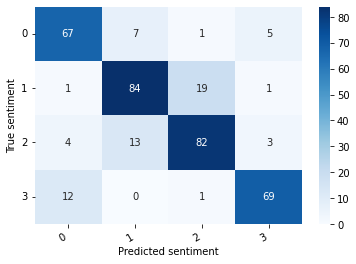

In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')
   
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm)

show_confusion_matrix(df_cm)
